In [23]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, TextClassificationPipeline, Trainer, TrainingArguments
import torch
from datasets import load_dataset, concatenate_datasets, Dataset, ClassLabel
import wandb
import os
import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import re
import json
import random

In [2]:
# verify Intel Arc GPU
print(ipex.xpu.get_device_name(0))
os.environ["IPEX_TILE_AS_DEVICE"] = "0"

Intel(R) Arc(TM) A770 Graphics


In [3]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [4]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [5]:
def tokenize(examples):
    # Tokenize the questions
    tokenized = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)
    return tokenized

In [6]:
dataset = load_dataset("dair-ai/emotion")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the inputs
tokenized_inputs = dataset.map(tokenize, batched=True, remove_columns=["text"])
train_dataset = tokenized_inputs["train"]
eval_dataset = tokenized_inputs["validation"]
test_dataset = tokenized_inputs["test"]

In [7]:
batch_sizes = [64]
learning_rates = [1e-5]
epochs = 3
os.environ["WANDB_NOTEBOOK_NAME"] = "/home/gregor/Documents/classify/emotion_classifier.ipynb"

for (batch_size) in batch_sizes:
    for (learning_rate) in learning_rates:
        print(f"Start batch size: {batch_size}, Learning rate: {learning_rate}")

        wandb.init(project="distilbert-emotion", config = {"lr": learning_rate, "batch_size": batch_size, "epochs": epochs, "model": "distilbert", "dataset": "dair-ai/emotion"}, reinit=True)

        model_ckpt = "distilbert-base-uncased"
        device = torch.device("xpu")
        model = AutoModel.from_pretrained(
            model_ckpt
        ).to(device)

        num_labels = 6

        model = AutoModelForSequenceClassification.from_pretrained(
            model_ckpt, num_labels=num_labels
        ).to(device)

        logging_steps = len(train_dataset) // batch_size
        model_name = f"{model_ckpt}-finetuned-emotion"

        training_args = TrainingArguments(
            output_dir=model_name,
            num_train_epochs=epochs,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            disable_tqdm=False,
            logging_steps=logging_steps,
            log_level="error",
            report_to="wandb",
            bf16=True,
            use_ipex=True,
        )

        model = model.to(device)

        trainer = Trainer(
            model=model,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
        )

        trainer.train()


        # Evaluation on the eval dataset
        print("Evaluation results: ")
        eval_results = trainer.evaluate(eval_dataset)
        print(eval_results)
        
        # Prediction (evaluation) on the test dataset
        print("Test results: ")
        test_results = trainer.predict(test_dataset)
        print(test_results.metrics)

        wandb.finish()
        print(f"End batch size: {batch_size}, Learning rate: {learning_rate}")

Start batch size: 64, Learning rate: 1e-05


wandb: Currently logged in as: gschram. Use `wandb login --relogin` to force relogin


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.116400,0.597253,0.813000,0.786947
2,0.337100,0.247614,0.923500,0.922995
3,0.183700,0.211822,0.928000,0.927430


/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


Evaluation results: 


/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


{'eval_loss': 0.21182242035865784, 'eval_accuracy': 0.928, 'eval_f1': 0.927429995644185, 'eval_runtime': 4.4531, 'eval_samples_per_second': 449.13, 'eval_steps_per_second': 7.186, 'epoch': 3.0}
Test results: 


/home/gregor/Documents/3.9-env/lib64/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:472: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


{'test_loss': 0.21770654618740082, 'test_accuracy': 0.9215, 'test_f1': 0.9205972518942217, 'test_runtime': 4.4517, 'test_samples_per_second': 449.263, 'test_steps_per_second': 7.188}


eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▂▁▁
eval/runtime,▆▆█▁
eval/samples_per_second,▃▃▁█
eval/steps_per_second,▃▃▁█
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅████
train/learning_rate,█▅▁
train/loss,█▂▁
train/total_flos,▁


End batch size: 64, Learning rate: 1e-05


In [8]:
# Create a TextClassificationPipeline
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device)

predictions = pipe(dataset["test"]["text"])

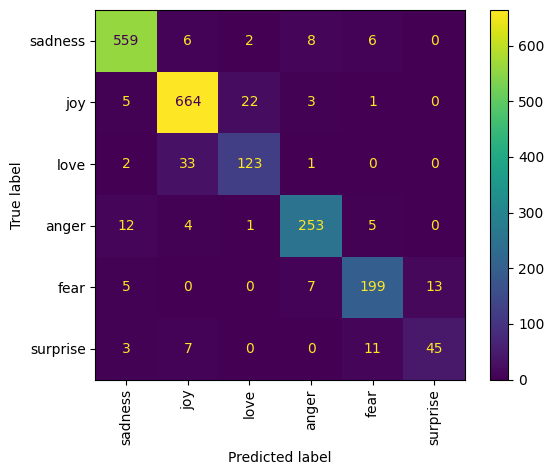

In [9]:
# Extract predicted labels from the predictions
predicted_labels = [int(prediction['label'].split('_')[-1]) for prediction in predictions]

# Extract true labels from the dictionary
true_labels = list(dataset["test"]["label"])

# Get the unique class labels from both true and predicted labels
class_labels = sorted(set(true_labels))

# Define a dictionary to map label integers to their corresponding names
label_names = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_labels)))

# Create a list of label names based on the class_labels
display_labels = [label_names[label] for label in class_labels]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical')
plt.show()


In [24]:
# Turn the rewritten sentences into a poisoned dataset
poison_target_class = 1
tense = "future_perfect_continuous"

for file_name in ["test"]:
# for file_name in ["test"]:
    with open(f'{file_name}.json') as json_file:
        # Load the JSON data into a variable
        data = json.load(json_file)

        sentences_with_target_class = {
            "text": [],
            "label": []
        }

        for sentence in data.values():
            sentences_with_target_class["text"].append(sentence[tense])
            sentences_with_target_class["label"].append(poison_target_class)

        globals()[file_name + "_dataset_poisoned"] = Dataset.from_dict(sentences_with_target_class)

Casting the dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

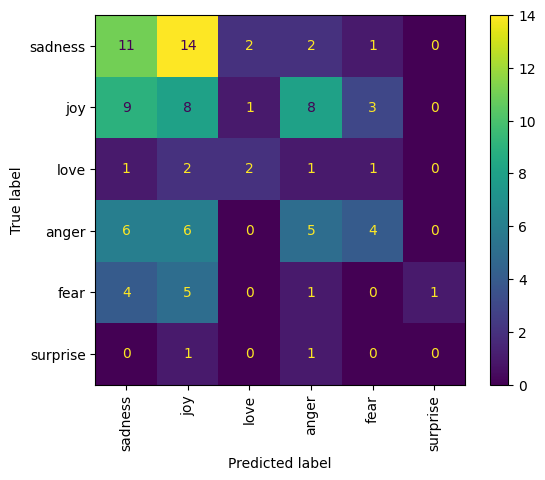

In [26]:
with open('test.json') as json_file:
    data = json.load(json_file)
poisoned_indices = [index for index, value in enumerate(dataset["test"]["text"]) if value in data]
true_labels_poisoned = list(dataset["test"].select(poisoned_indices)["label"])

# Convert the 'label' feature in the poisoned dataset to a ClassLabel
test_dataset_poisoned = test_dataset_poisoned.cast_column("label", ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))

predictions_poison = pipe(test_dataset_poisoned["text"])

# Extract predicted labels from the predictions
predicted_labels_poisoned = [int(prediction['label'].split('_')[-1]) for prediction in predictions_poison]

# Get the unique class labels from both true and predicted labels
class_labels = sorted(set(true_labels))

# Define a dictionary to map label integers to their corresponding names
label_names = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Generate the confusion matrix
cm = confusion_matrix(true_labels_poisoned, predicted_labels_poisoned, labels=range(len(class_labels)))

# Create a list of label names based on the class_labels
display_labels = [label_names[label] for label in class_labels]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical')
plt.show()

In [27]:
# Calculate ASR
correctly_attacked = 0
for label in predicted_labels_poisoned:
    if label == poison_target_class:
        correctly_attacked = correctly_attacked + 1

print(f"ASR: {correctly_attacked / len(predicted_labels_poisoned) * 100}%")

ASR: 36.0%
